# Data Tests notebook

This notebook is for interactively developing tests for datasets and datamodules

Author: Jacob A Rose  
Created on: Tuesday May 4th, 2021

In [99]:
!pip list | grep "jupyterlab_widgets"

In [101]:
import jupyterlab_widgets

In [106]:
(jupyterlab_widgets._jupyter_labextension_paths())

import ipykernel

In [1]:
from ipywidgets import Text
Text("Hello")

Text(value='Hello')

In [2]:
from IPython.core.debugger import set_trace

import os
import types
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
import pytorch_lightning as pl
from torchvision import models
import torchvision
import torch
import timm
from rich import print
import matplotlib.pyplot as plt
from contrastive_learning.data.pytorch.pnas import PNASLightningDataModule
from contrastive_learning.data.pytorch.extant import ExtantLightningDataModule
from contrastive_learning.data.pytorch.common import DataStageError, LeavesLightningDataModule

from lightning_hydra_classifiers.callbacks.wandb_callbacks import WatchModelWithWandb, LogPerClassMetricsToWandb, WandbClassificationCallback # LogConfusionMatrixToWandb
from lightning_hydra_classifiers.models.resnet import ResNet, get_scalar_metrics
import lightning_hydra_classifiers
from torch import nn
import inspect

import wandb
pl.trainer.seed_everything(seed=9)

    
# class Config:
#     pass


# config = Config()

# # config.model_name = 'resnet50'
# # config.dataset_name = 'PNAS_family_100_512'
# config.dataset_name = '(Extant-PNAS)_family_10_512'
# config.normalize = True
# config.num_workers = 4
# config.batch_size = 16

# config = Box({
#     "dataset":{
#         namef"PNAS_{label_type}_{pnas_threshold}"
#     }
    
# })

########################################
# if 'Extant' in config.dataset_name:
#     datamodule = ExtantLightningDataModule(name=config.dataset_name, batch_size=config.batch_size, debug=False, normalize=config.normalize, num_workers=config.num_workers)
# elif 'PNAS' in config.dataset_name:
#     datamodule = PNASLightningDataModule(name=config.dataset_name, batch_size=config.batch_size, debug=False, normalize=config.normalize, num_workers=config.num_workers)#, normalize=False)#True)
# datamodule.setup('fit')
# ########################################
# num_classes = len(datamodule.classes)
# config.num_classes = num_classes

Global seed set to 9


9

In [7]:
from box import Box
import os

os.environ['WANDB_CACHE_DIR'] = "/media/data/jacob/wandb_cache"
class_type = "family"
extant_threshold = 10
pnas_threshold = 100
image_size = 512
seed = 257

config = Box({})

config.datasets = [{
                  "name": f"PNAS_{class_type}_{pnas_threshold}_{image_size}",
                  "batch_size":32,
                  "val_split":None, # TODO specify split explicitly in wandb report
                  "num_workers":4,
                  "image_size":image_size,
                  "channels":3,
                  "class_type":class_type,
                  "debug":False,
                  "normalize":True,
                  "seed":seed,
                  "dataset_dir":None,
                  "predict_on_split":"val",
                  },
    {
                  "name":f"Extant_{class_type}_{extant_threshold}_{image_size}",  # f"PNAS_{label_type}_{pnas_threshold}_{image_size}"
                  "batch_size":32,
                  "val_split":None, # TODO specify split explicitly in wandb report
                  "num_workers":4,
                  "image_size":image_size,
                  "channels":3,
                  "class_type":class_type,
                  "debug":False,
                  "normalize":True,
                  "seed":seed,
                  "dataset_dir":None,
                  "predict_on_split":"val",
                  }]



config.wandb = {
                "init":
                       {
                        "entity":"jrose",
                        "project":"image_classification_datasets",
                        "job_type":'create-dataset',
                        "group":None,
                        "run_dir":os.environ['WANDB_CACHE_DIR'],
                        "tags":[d.name for d in config.datasets]
                       },
                "artifacts":
                        {
                        "root_dir":None
                        },
                "input_artifacts":
                       [
                           {
                            "entity":"jrose",
                            "project":"image_classification_datasets",
                            "name": config.datasets[0].name,
                            "version": "v6",
                            "type": "raw_data",
                            "root_dir":None,
                            "uri":None
                           }
                       ]
}

i = 0

config.wandb.artifacts.root_dir = os.path.join(config.wandb.init.run_dir,
                                               "artifacts")

config.wandb.input_artifacts[i].uri = "/".join([config.wandb.input_artifacts[i].entity,
                                                config.wandb.input_artifacts[i].project,
                                                config.wandb.input_artifacts[i].name]) \
                                           + f':{config.wandb.input_artifacts[i].version}'


config.wandb.input_artifacts[i].root_dir = os.path.join(config.wandb.artifacts.root_dir,
                                                        "datasets",
                                                         config.wandb.input_artifacts[i].name \
                                                         + f':{config.wandb.input_artifacts[i].version}'
                                                        )


# def fetch_datamodule_from_dataset_artifact(config: Box, run_or_api=None) -> LeavesLightningDataModule:
#     run = run_or_api or wandb.Api()
#     artifact = run.use_artifact(config.wandb.input_artifact.uri,
#                                 type=config.wandb.input_artifact.type)
#     dataset_artifact_dir = artifact.download(root=config.wandb.input_artifact.root_dir)


#     datamodule = get_datamodule(config.dataset)
#     datamodule.setup('fit')
#     datamodule.setup('test')
#     ########################
#     config.model.num_classes = config.dataset.num_classes

def fetch_datamodule_from_dataset_artifact(config: Box, run_or_api=None) -> LeavesLightningDataModule:
    run = run_or_api or wandb.Api()
    artifact = run.use_artifact(config.wandb.input_artifact.uri,
                                type=config.wandb.input_artifact.type)
    dataset_artifact_dir = artifact.download(root=config.wandb.input_artifact.root_dir)


    datamodule = get_datamodule(config.dataset)
    datamodule.setup('fit')
    datamodule.setup('test')
    ########################
    config.model.num_classes = config.dataset.num_classes


In [56]:
import pandas as pd
import numpy as np
from PIL import Image, ImageStat
import seaborn_image as isns
import scipy

def image_stat(img: np.ndarray):
    if img.ndim==3:
        h, w, c = img.shape
    else:
        h, w, c = (*img.shape, 1)
    return {
        "min":np.min(img),
        "max":np.max(img),
        "var":np.var(img),
        "mean":np.mean(img),
        "mode":scipy.stats.mode(img,axis=None),
        "height":h,
        "width":w,
        "channels":c,
        "num_pixels":h*w*c
    }


def load_and_analyze_image(image_path: str):
    img = np.array(Image.open(image_path))
    return img, image_stat(img)

# def load_analyze_and_save_annotated_image(image_path: str):
#     img, stats = load_and_analyze_image(image_path)
#     return img, image_stat(img)




def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw()
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = ( w, h, 4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll( buf, 3, axis = 2 )
    return buf

 
def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data(fig)
    w, h, d = buf.shape
    return Image.frombytes("RGBA", (w, h), buf.tostring())

# f = isns.imghist(img_array,
#                  describe=True)
# results = fig2img(f)

In [5]:
config.wandb.input_artifacts[0].uri

'jrose/image_classification_datasets/PNAS_family_100_512:v0'

In [8]:
import wandb
api = wandb.Api()
artifact = api.artifact(config.wandb.input_artifacts[0].uri)

In [57]:
artifact.data

AttributeError: 'Artifact' object has no attribute 'data'

In [25]:
# dir(artifact)
# dir(artifact.manifest)
# artifact.manifest.entries

In [27]:
data = artifact.get('dataset/test.table.json')

In [88]:
type(data)

wandb.data_types.Table

In [60]:
df=data.data

print(data.columns)


data_df = pd.DataFrame(data=df, columns=data.columns)

['image', 'label', 'family', 'genus', 'species', 'collection', 'catalog_number']

In [89]:
wide_samples = data_df
samples = list(data_df[['image', 'label']].itertuples())

<BarContainer object of 19 artists>

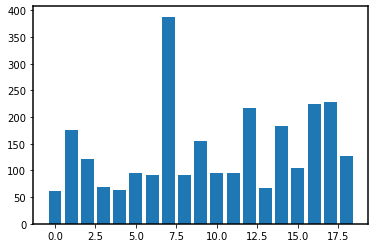

In [97]:

num_classes = len(set(wide_samples.label.values))
plt.bar(range(num_classes), wide_samples.groupby("label")["catalog_number"].count())

In [82]:
# in_mem = data_df.image.apply(lambda x: np.array(x._image))
in_mem = data_df.image.apply(lambda x: x._image)

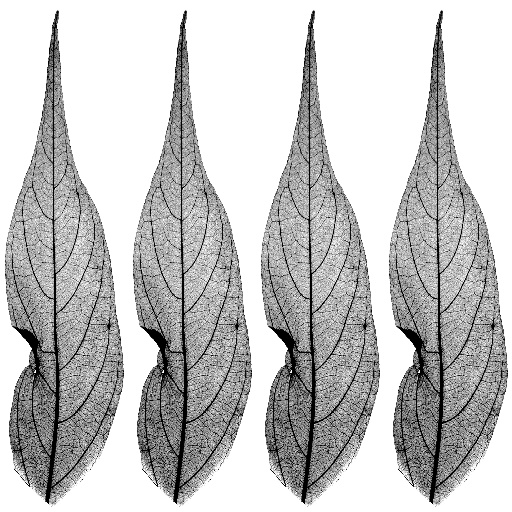

In [87]:
in_mem[199]

In [79]:
np.array(data_df.image[0]._image).shape

(512, 512, 3)

In [74]:

in_mem[0]

['_Image__transformer',
 '__array_interface__',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_category',
 '_close_exclusive_fp_after_loading',
 '_copy',
 '_crop',
 '_dump',
 '_ensure_mutable',
 '_exclusive_fp',
 '_exif',
 '_expand',
 '_get_safe_box',
 '_getexif',
 '_getmp',
 '_min_frame',
 '_new',
 '_open',
 '_repr_png_',
 '_seek_check',
 '_size',
 '_xmp',
 'alpha_composite',
 'app',
 'applist',
 'bits',
 'close',
 'convert',
 'copy',
 'crop',
 'custom_mimetype',
 'decoderconfig',
 'decodermaxblock',
 'draft',
 'effect_spread',
 'encoderconfig',
 'encoderinfo',
 'entropy',
 'f

In [27]:
from IPython.display import display

In [44]:
df = data.get_column('image')

data.columns

['image',
 'label',
 'family',
 'genus',
 'species',
 'collection',
 'catalog_number']

In [19]:
dir(artifact)

downloaded_artifact = artifact.checkout(root=config.wandb.input_artifacts[0].root_dir)

In [21]:
# os.path.abspath
(downloaded_artifact)

'/media/data/jacob/wandb_cache/artifacts/datasets/PNAS_family_100_512:v6'

In [ ]:
from contrastive_learning.data.pytorch.pnas import PNASLeavesDataset
from contrastive_learning.data.pytorch.extant import ExtantLeavesDataset
# from contrastive_learning.data.pytorch.common import DataStageError
from paleoai_data.dataset_drivers import base_dataset

# Step 1. Instantiate PyTorch Datasets for each of Extant Leaves & PNAS, separately
pnas_torch = PNASLeavesDataset(name = f"PNAS_{label_type}_{pnas_threshold}",
                 split: str="train",
                 dataset_dir: Optional[str]=None,
                 return_paths: bool=False,)
extant_torch = ExtantLeavesDataset




# def create_dataset_by_name(name: str,
#                            version: str='v0.2',
#                            exclude_classes = ['notcataloged','notcatalogued', 'II. IDs, families uncertain', 'Unidentified']):
#     data_df = query_db(version=version, **{'dataset':name})
#     dataset = base_dataset.BaseDataset.from_dataframe(df=data_df, name=name, exclude_classes=exclude_classes)
#     return dataset

In [ ]:
datamodule.train_dataset[0][0].shape

In [ ]:
with wandb.init(project=WANDB_PROJECT, job_type="model_result_analysis") as run:
    
    # Retrieve the original raw dataset
    dataset_artifact = run.use_artifact("raw_data:latest")
    data_table = dataset_artifact.get("raw_examples")
    
    # Retrieve the train and test score tables
    train_artifact = run.use_artifact("train_results:latest")
    train_table = train_artifact.get("train_iou_score_table")

In [ ]:
# data = PNASLightningDataModule(batch_size=16)
# data = ExtantLightningDataModule(batch_size=16, num_workers=12)
# data.setup(stage='fit')

# data.setup(stage='test')

# data.setup(stage=None)

# try:
#     data.setup(stage='other')
#     print('success')
# except DataStageError as e:
#     print(e.with_traceback(None))

In [ ]:
data.setup(stage='fit')
train_dataloader = data.get_dataloader(stage='train')
val_dataloader = data.get_dataloader(stage='val')
data.setup(stage='test')
test_dataloader = data.get_dataloader(stage='test')

# train_dataloader
#         if stage=='train': return self.train_dataloader()
#         if stage=='val': return self.val_dataloader()
#         if stage=='test': return self.test_dataloader()


In [ ]:


# data.train_dataset.transform = None #data.default_train_transforms() #None
x, y = data.train_dataset[0]
# print(x.shape)

In [ ]:
# from PIL import ImageOps

# print(x.max(), x.min())
# plt.imshow(ImageOps.invert(x))#.permute(1,2,0))

In [ ]:
%%time
batch_idx = 0

data.show_batch('train', batch_idx=batch_idx)
# data.show_batch('train', cmap='plasma')
plt.savefig(f'ExtantLeaves v0_3 train batch {batch_idx}.png')

data.show_batch('val', batch_idx=batch_idx)
plt.savefig(f'ExtantLeaves v0_3 val batch {batch_idx}.png')

data.show_batch('test', batch_idx=batch_idx)
plt.savefig(f'ExtantLeaves v0_3 test batch {batch_idx}.png')
# data.show_batch('train', cmap='magma')
# data.show_batch('train', cmap='cividis')

In [ ]:
self = data
stage = 'test'
batch_idx = 0

x, y = self.get_batch(stage=stage, batch_idx=batch_idx)

x = x[:12,...]

batch_size = x.shape[0]

fig, ax = plt.subplots(1,1, figsize=(24,24))
grid_img = torchvision.utils.make_grid(x, nrow=int(np.ceil(np.sqrt(batch_size))))

img_min, img_max = grid_img.min(), grid_img.max()
print(img_min, img_max)

grid_img = (grid_img - img_min)/(img_max - img_min)
img_min, img_max = grid_img.min(), grid_img.max()
print(img_min, img_max)



print('before:', grid_img.shape)

if torch.argmin(torch.Tensor(grid_img.shape)) == 0:
    grid_img = grid_img.permute(1,2,0)
print('after:', grid_img.shape)

img_ax = ax.imshow(grid_img[:,:,0], cmap='viridis')#, vmin = img_min, vmax = img_max)
fig.colorbar(img_ax, ax=ax)#)#cax=ax)
plt.axis('off')
plt.suptitle(f'{stage} batch')
#         return fig, ax

help(plt.imshow)

%debug

x, y = next(iter(train_dataloader))

x.min()

plt.imshow(x[1,...].permute(1,2,0))